# Final Team Project
## Group 2:
- ***Dipraj Bista***
- ***Landon Padgett***
- ***Ghassan Seba***

In [1]:
# Import Libraries
import time
import string
import spacy
import seaborn as sns
import requests
import re
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
import pyLDAvis
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models
from collections import Counter
from bs4 import BeautifulSoup

nlp = spacy.load('en_core_web_sm')

## Establishing Text Cleaning and Tokenization Functions for SEC Data
*This code defines functions to clean, tokenize, and lemmatize SEC filing text, removing boilerplate and irrelevant content. These functions form a preprocessing pipeline to prepare text for analysis.*

In [2]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

# Load the English stopwords from NLTK
stopwords_list = stopwords.words('english')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the stopwords, including custom stopwords specific to the domain
custom_stopwords = set(stopwords.words('english')).union({
    'herein', 'thereof', 'aforementioned', 'form', '8-k', 'nvidia', 'corporation', 'securities', 'exchange',
    'commission', 'share', 'meeting', 'vote', 'registrant', 'item', 'section', 'pursuant', 'act', 'inc', 'llc'
})

def clean_text(text):
    """Performs enhanced text cleaning to remove legal boilerplate and irrelevant characters."""
    # Remove common boilerplate phrases and legal text patterns
    text = re.sub(r'UNITED STATES SECURITIES AND EXCHANGE COMMISSION', '', text, flags=re.IGNORECASE)
    text = re.sub(r'FORM 8-K', '', text, flags=re.IGNORECASE)
    text = re.sub(r'CURRENT REPORT PURSUANT TO SECTION [0-9]+ OF THE SECURITIES EXCHANGE ACT OF 1934', '', text, flags=re.IGNORECASE)

    # Add spaces between numbers and words (ensures proper spacing in cases like 'for398number')
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)
    
    # Normalize dates and numbers
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}\b', ' [DATE] ', text)
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove unwanted characters and special symbols
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\\x\w{2}', '', text)
    text = re.sub(r'[☐]', '', text)
    
    # Remove punctuation, while keeping periods for potential sentence segmentation
    text = re.sub(r'[^\w\s\.\-]', '', text)
    
    # Remove single characters followed by a period (e.g., 'a.', 'm.', 'c.')
    text = re.sub(r'\b[a-zA-Z]\.\b', '', text)
    
    return text

def tokenize(text):
    """Tokenizes, lemmatizes, and removes stopwords, including filtering out single characters."""
    tokens = re.split(r'\s+', text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in custom_stopwords and len(token) > 1]
    return tokens

def prepare(text, pipeline):
    """Prepares text by applying a sequence of cleaning and transformation steps."""
    for transform in pipeline:
        text = transform(text)
    return text

# Define the text preprocessing pipeline
pipeline = [clean_text, tokenize]

# Function to preprocess the 'Disclosure Text' column in the existing DataFrame
def preprocess_disclosure_text(df):
    """Applies text preprocessing to the 'Disclosure Text' column of the existing DataFrame."""
    df['Processed Disclosure Text'] = df['Disclosure Text'].apply(
        lambda x: ' '.join(prepare(x, pipeline)) if isinstance(x, str) else ''
    )
    return df


## Functions for Extracting and Generating URLs for SEC Form 8-K Filings
*This code defines functions to extract data from HTML tables, parse SEC filing content, and generate URLs for Form 8-K filings. It processes HTML elements to extract disclosure items, converts them into structured text, and constructs URLs for accessing specific filings using the SEC's index file.*

In [3]:
# Extract data from HTML table and format it as a string
def extract_table_data(table):
    rows = table.find_all('tr')
    table_text = [' | '.join(cell.get_text(strip=True) for cell in row.find_all(['td', 'th'])) for row in rows]
    return '\n'.join(table_text)

# Extract disclosure items and tables from HTML content
def extract_nvda_disclosures_xml(soup):
    items_content = {}
    current_item = None
    div_elements = soup.find_all(['div', 'table'])

    for element in div_elements:
        if element.name == 'div':
            text = element.get_text(strip=True)
            if "Item" in text:
                current_item = text
                items_content[current_item] = []
            elif current_item:
                items_content[current_item].append(text)
        elif element.name == 'table':  # Process table data
            table_data = extract_table_data(element)
            if current_item:
                items_content[current_item].append(table_data)

    for item, content_list in items_content.items():
        items_content[item] = ' '.join(content_list)

    return items_content

# Generate Form 8-K filing URLs using the SEC's index.json file
def generate_form_8k_urls(cik_number, accession_numbers):
    filing_urls = []
    base_url = f'https://www.sec.gov/Archives/edgar/data/{int(cik_number)}/'
    headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: your_email@example.com)"}

    for accession_number in accession_numbers:
        formatted_accession = accession_number.replace('-', '')
        index_url = f"{base_url}{formatted_accession}/index.json"
        response = requests.get(index_url, headers=headers)
        time.sleep(1)  # Rate limiting

        if response.status_code == 200:
            try:
                data = response.json()
                for file_info in data.get('directory', {}).get('item', []):
                    if file_info['name'].lower().endswith('.htm') and '8-k' in file_info['name'].lower():
                        filing_urls.append(f"{base_url}{formatted_accession}/{file_info['name']}")
            except ValueError:
                print(f"Error parsing JSON at {index_url}")
        else:
            print(f"Failed to retrieve index for {accession_number}, status code {response.status_code}")

    return filing_urls

## Retrieving and Formatting Company Data from the SEC Edgar Database

*This code retrieves company ticker data from the SEC Edgar database, processes it into a pandas DataFrame, and formats CIK numbers with leading zeros for URL compatibility. The resulting DataFrame is then displayed.*

In [4]:
# Define Base URL
base_url = r"https://www.sec.gov/Archives/edgar/data"

# Set up the headers with User-Agent
headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: gseba@sandiego.edu)"}

# Get all companies data
tickers_json = requests.get("https://www.sec.gov/files/company_tickers.json", headers=headers)

In [5]:
# Format response as a dictionary and get first key/value
frist_entry = tickers_json.json()['0']

# Get CIK Numbers 
raw_cik = tickers_json.json()['0']['cik_str']

# Convert to a data frame
cik_df = pd.DataFrame.from_dict(tickers_json.json(), orient='index')

# Add leading zeros to CIK numbers for URL formatting
cik_df['cik_str'] = cik_df['cik_str'].astype(str).str.zfill(10)

# Display Data Frame
cik_df.head()

,cik_str,ticker,title
0,0000320193,AAPL,Apple Inc.
1,0001045810,NVDA,NVIDIA CORP
2,0000789019,MSFT,MICROSOFT CORP
3,0001652044,GOOGL,Alphabet Inc.
4,0001018724,AMZN,AMAZON COM INC


## Automating SEC Filing Data Retrieval and URL Generation
*This code retrieves and processes company filing metadata from the SEC Edgar database using a CIK number to generate URLs for specific filings. It organizes the data into a DataFrame, identifies filing types, and filters for '8-K' reports, displaying accession numbers to ensure accurate file access via URL links.*

In [6]:
# Find CIK number using a company's ticker symbol
def get_cik_number_by_ticker(df, ticker_symbol):
    """
    Parameters:
    df (pd.DataFrame): DataFrame with 'ticker' and 'cik_str' columns.
    ticker_symbol (str): Company's ticker symbol.

    Returns:
    str: CIK number if the ticker symbol is found, or a message if not found.
    """
    result = df.loc[df['ticker'] == ticker_symbol, 'cik_str']  # Filter by ticker symbol
    
    if not result.empty:
        cik_number = result.iloc[0]  # Extract first matching CIK number
        return cik_number
    else:
        return f"Ticker symbol '{ticker_symbol}' not found in the dataset."

# Search for CIK number using ticker
ticker_to_search = 'NVDA'
cik_number = get_cik_number_by_ticker(cik_df, ticker_to_search)

# Retrieve company filing metadata using CIK number
def get_filing_metadata(cik_number):
    """
    Parameters:
    cik_number (str): Company's CIK number.

    Returns:
    dict or None: Parsed JSON data if successful, otherwise None.
    """
    url = f'https://data.sec.gov/submissions/CIK{cik_number}.json'
    response = requests.get(url, headers=headers)

    # Check response status before parsing JSON
    if response.status_code == 200:
        try:
            data = response.json()
            print("Successfully retrieved JSON data.")
            return data
        except ValueError as e:
            print("Error parsing JSON:", e)
            print("Response Content (Preview):", response.text[:500])
            return None
    else:
        print(f"Failed to retrieve data. Status Code: {response.status_code}")
        print("Response Content (Preview):", response.text[:500])
        return None

# Retrieve filing metadata
filing_metadata = get_filing_metadata(cik_number)

# Process filing metadata if retrieved successfully
if filing_metadata:
    print(filing_metadata.keys())  # Display top-level keys in JSON
    filings = filing_metadata.get('filings', {}).get('recent', None)

    if filings:
        # Create DataFrame from recent filings
        forms_df = pd.DataFrame.from_dict(filings)
        print(forms_df.columns)  # Display DataFrame columns
    else:
        print("No recent filings found in JSON data.")


Successfully retrieved JSON data.
dict_keys(['cik', 'entityType', 'sic', 'sicDescription', 'ownerOrg', 'insiderTransactionForOwnerExists', 'insiderTransactionForIssuerExists', 'name', 'tickers', 'exchanges', 'ein', 'description', 'website', 'investorWebsite', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'stateOfIncorporationDescription', 'addresses', 'phone', 'flags', 'formerNames', 'filings'])
Index(['accessionNumber', 'filingDate', 'reportDate', 'acceptanceDateTime',
       'act', 'form', 'fileNumber', 'filmNumber', 'items', 'core_type', 'size',
       'isXBRL', 'isInlineXBRL', 'primaryDocument', 'primaryDocDescription'],
      dtype='object')


In [7]:
# Explore resulting data frame
forms_df.head()

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,core_type,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0001045810-24-000298,2024-10-11,2024-10-09,2024-10-11T17:42:48.000Z,,4,,,,4,6816,0,0,xslF345X05/wk-form4_1728682961.xml,FORM 4
1,0001045810-24-000296,2024-10-07,2024-10-03,2024-10-07T17:27:24.000Z,,4,,,,4,6816,0,0,xslF345X05/wk-form4_1728336437.xml,FORM 4
2,0001045810-24-000294,2024-10-01,2024-09-27,2024-10-01T16:19:18.000Z,,4,,,,4,6815,0,0,xslF345X05/wk-form4_1727813951.xml,FORM 4
3,0001045810-24-000292,2024-09-26,2024-09-24,2024-09-26T17:22:24.000Z,,4,,,,4,6818,0,0,xslF345X05/wk-form4_1727385738.xml,FORM 4
4,0001961863-24-000324,2024-09-24,,2024-09-24T17:58:48.000Z,33,144,000-23985,241320989,,144,247027,0,0,xsl144X01/primary_doc.xml,


In [8]:
# Explore the unique values in the 'form' column
forms_df['form'].unique()

array(['4', '144', '10-Q', '8-K', '13F-HR', '3', 'SC 13G', 'SD', 'ARS',
       'DEFA14A', 'DEF 14A', '10-K', 'SC 13G/A', '4/A', 'UPLOAD',
       'CORRESP', '144/A', 'EFFECT', 'S-3/A', 'S-3', 'S-8', 'PRE 14A',
       '5', '424B5', 'FWP', '5/A', '8-K/A', 'S-3ASR', 'DFAN14A'],
      dtype=object)

In [9]:
# Filter the DataFrame for the '8-K' form
eight_k_filings = forms_df[forms_df['form'] == '8-K']

# Check if there are any '8-K' reports and display a portion of the accession numbers
if not eight_k_filings.empty:
    accession_numbers = eight_k_filings['accessionNumber'].tolist()
    # Print only the first 5 accession numbers
    print("Accession numbers for '8-K' reports (first 5):", accession_numbers[:5])
else:
    print("No '8-K' reports found for the selected CIK number.")


Accession numbers for '8-K' reports (first 5): ['0001045810-24-000262', '0001045810-24-000206', '0001045810-24-000144', '0001045810-24-000113', '0001045810-24-000069']


## Scraping and Processing SEC Form 8-K Filings from the EDGAR Site
*This code scrapes Form 8-K filings for a given company using its ticker symbol from the SEC EDGAR site. It generates URLs for the filings, retrieves the content, and extracts disclosure items using BeautifulSoup. The scraped data, including CIK numbers, accession numbers, and disclosure text, is then organized into a DataFrame for analysis.*

In [10]:
# Process filings
ticker_symbol = 'NVDA'
cik_number = get_cik_number_by_ticker(cik_df, ticker_symbol)
filing_metadata = get_filing_metadata(cik_number)

if filing_metadata:
    filings = filing_metadata.get('filings', {}).get('recent', None)

    if filings:
        forms_df = pd.DataFrame.from_dict(filings)
        eight_k_filings = forms_df[forms_df['form'] == '8-K']

        if not eight_k_filings.empty:
            accession_numbers = eight_k_filings['accessionNumber'].tolist()
            filing_urls = generate_form_8k_urls(cik_number, accession_numbers)

            headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: your_email@example.com)"}
            for url in filing_urls:
                response = requests.get(url, headers=headers)
                time.sleep(1)

                if response.status_code == 200:
                    soup = BeautifulSoup(response.text, 'html.parser')
                    disclosure = extract_nvda_disclosures_xml(soup)
                    
                    # Uncomment the following lines to print the full disclosure output:
                    # print(f"{ticker_symbol} Form 8-K Disclosures:") 
                    # for item, content in disclosure.items():
                    #     print(f"{item}: {content}\n")
                    
                else:
                    print(f"Failed to fetch content for {url}")

            # Print separator for better readability
            # print("\n" + "-" * 40 + "\n")
        else:
            print("No '8-K' reports found.")
    else:
        print("No recent filings found.")
else:
    print("Failed to retrieve filing metadata.")


Successfully retrieved JSON data.


In [11]:
# Store results for DataFrame creation
data_list = []

if filing_metadata:
    filings = filing_metadata.get('filings', {}).get('recent', None)

    if filings:
        forms_df = pd.DataFrame.from_dict(filings)
        eight_k_filings = forms_df[forms_df['form'] == '8-K']

        if not eight_k_filings.empty:
            accession_numbers = eight_k_filings['accessionNumber'].tolist()
            filing_urls = generate_form_8k_urls(cik_number, accession_numbers)

            headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: your_email@example.com)"}
            for url in filing_urls:
                response = requests.get(url, headers=headers)
                time.sleep(1)

                if response.status_code == 200:
                    filing_content = response.text
                    soup = BeautifulSoup(filing_content, 'html.parser')
                    disclosure = extract_nvda_disclosures_xml(soup)

                    # Append formatted disclosure data to the list
                    for item, content in disclosure.items():
                        formatted_content = content.replace(' | ', '\n')  # Ensure table data is separated properly
                        data_list.append({
                            'CIK': cik_number,
                            'Accession Number': url.split('/')[-2],
                            'Item': item,
                            'Disclosure Text': formatted_content
                        })
                else:
                    print(f"Failed to fetch filing content for URL: {url}")
        else:
            print("No '8-K' reports found for the selected CIK number.")
    else:
        print("No recent filings found in the JSON data.")
else:
    print("Failed to retrieve filing metadata.")

# Create DataFrame from the results
filing_df = pd.DataFrame(data_list, columns=['CIK', 'Accession Number', 'Item', 'Disclosure Text'])

In [12]:
# Display the full text of the 'Item' column in your DataFrame
filing_df.head()

,CIK,Accession Number,Item,Disclosure Text
0,0001045810,000104581020000103,false000104581000010458102020-06-092020-06-09U...,false000104581000010458102020-06-092020-06-09 ...
1,0001045810,000104581020000103,Item 5.02. Departure of Directors or Certain O...,Amendment and Restatement of Amended and Resta...
2,0001045810,000104581020000103,Item 5.07. Submission of Matters to a Vote of ...,"At the 2020 Annual Meeting, the following pro..."
3,0001045810,000104581020000103,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription...
4,0001045810,000104581020000052,false000104581000010458102020-04-272020-04-27U...,false000104581000010458102020-04-272020-04-27 ...


## Preprocessing SEC Form 8-K Data with Text Cleaning and Tokenization
*This code applies text cleaning, tokenization, and lemmatization functions to preprocess Form 8-K disclosure data from the SEC EDGAR site. It organizes the data by converting report dates, merging columns, and handling missing values. The cleaned and tokenized disclosure text is combined with other filing details into a structured DataFrame for further analysis, ensuring proper date handling and eliminating incomplete entries.*

In [13]:
# Apply preprocessing to the 'Disclosure Text' column in your existing DataFrame
filing_df = preprocess_disclosure_text(filing_df)

# Display the DataFrame with the processed disclosure text
filing_df.head()

,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
0,0001045810,000104581020000103,false000104581000010458102020-06-092020-06-09U...,false000104581000010458102020-06-092020-06-09 ...,false ---- washington dc ______________ -k cur...
1,0001045810,000104581020000103,Item 5.02. Departure of Directors or Certain O...,Amendment and Restatement of Amended and Resta...,amendment restatement amended restated equity ...
2,0001045810,000104581020000103,Item 5.07. Submission of Matters to a Vote of ...,"At the 2020 Annual Meeting, the following pro...",annual following proposal adopted margin indic...
3,0001045810,000104581020000103,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription...,exhibit exhibit numberdescription amended rest...
4,0001045810,000104581020000052,false000104581000010458102020-04-272020-04-27U...,false000104581000010458102020-04-272020-04-27 ...,false ---- washington dc ______________ -k cur...


In [14]:
# Convert 'reportDate' to datetime
filing_df['reportDate'] = pd.to_datetime(forms_df['reportDate'], errors='coerce')

# Reorder columns with 'reportDate' first
columns_order = ['reportDate', 'CIK', 'Accession Number', 'Item', 'Disclosure Text', 'Processed Disclosure Text']
filing_df = filing_df[columns_order]

# Merge 'reportDate' into 'filing_df' using 'Accession Number' with suffixes
filing_df = filing_df.merge(forms_df[['accessionNumber', 'reportDate']],
                            left_on='Accession Number',
                            right_on='accessionNumber',
                            how='left',
                            suffixes=('_filing', '_form'))

# Drop redundant 'accessionNumber' and 'reportDate_form' columns
filing_df.drop(columns=['accessionNumber', 'reportDate_form'], inplace=True)

# Rename 'reportDate_filing' to 'reportDate'
filing_df.rename(columns={'reportDate_filing': 'reportDate'}, inplace=True)

# Display updated DataFrame
filing_df.head()

,reportDate,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
0,2024-10-09,0001045810,000104581020000103,false000104581000010458102020-06-092020-06-09U...,false000104581000010458102020-06-092020-06-09 ...,false ---- washington dc ______________ -k cur...
1,2024-10-03,0001045810,000104581020000103,Item 5.02. Departure of Directors or Certain O...,Amendment and Restatement of Amended and Resta...,amendment restatement amended restated equity ...
2,2024-09-27,0001045810,000104581020000103,Item 5.07. Submission of Matters to a Vote of ...,"At the 2020 Annual Meeting, the following pro...",annual following proposal adopted margin indic...
3,2024-09-24,0001045810,000104581020000103,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription...,exhibit exhibit numberdescription amended rest...
4,NaT,0001045810,000104581020000052,false000104581000010458102020-04-272020-04-27U...,false000104581000010458102020-04-272020-04-27 ...,false ---- washington dc ______________ -k cur...


In [15]:
# Clean, normalize, and extract first 8 characters of Item column
filing_df['Item'] = (
    filing_df['Item']
    .str.strip()  # Remove extra spaces
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove non-alphanumeric characters
    .str.replace(r'\s+', ' ', regex=True)  # Collapse multiple spaces
    .str[:8]  # Extract first 8 characters
    .str.upper()  # Convert to uppercase
    .apply(lambda x: re.sub(r'[\x00-\x1F\x7F]', '', x))  # Remove non-printable chars
)


# Count unique items in the 'Item' column
unique_item_counts = filing_df['Item'].value_counts()

# Display the unique counts
print(unique_item_counts)

# Optional: Display the total number of unique items
print(f"\nTotal unique items: {unique_item_counts.nunique()}")

Item
ITEM 901    30
ITEM 202    16
ITEM 502     9
ITEM 101     5
FALSE000     4
ITEM 507     4
THE INFO     3
 CERTAIN     2
ITEM 302     2
ITEM 201     1
THE FINA     1
THE PRO      1
ITEM 801     1
ITEM 203     1
ITEM 102     1
ITEM 503     1
Name: count, dtype: int64

Total unique items: 8


In [16]:
# Only keep rows with disclosures in the 'Item' column to
filing_df = filing_df[filing_df['Item'].str.contains(r'^ITEM', regex=True)]

# Display filtered DataFrame
filing_df.head()

,reportDate,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
1,2024-10-03,0001045810,000104581020000103,ITEM 502,Amendment and Restatement of Amended and Resta...,amendment restatement amended restated equity ...
2,2024-09-27,0001045810,000104581020000103,ITEM 507,"At the 2020 Annual Meeting, the following pro...",annual following proposal adopted margin indic...
3,2024-09-24,0001045810,000104581020000103,ITEM 901,(d) Exhibits Exhibit NumberDescription...,exhibit exhibit numberdescription amended rest...
5,2024-09-20,0001045810,000104581020000052,ITEM 201,"On April 27, 2020, NVIDIA Corporation, a Dela...",april delaware company completed previously an...
6,2024-09-19,0001045810,000104581020000052,ITEM 901,(a) Financial Statements of Business Acqu...,financial statement business acquired.


In [17]:
# Recalculate and display unique item counts
unique_item_counts = filing_df['Item'].value_counts()
print(unique_item_counts)
print(f"\nTotal unique items: {unique_item_counts.nunique()}")

Item
ITEM 901    30
ITEM 202    16
ITEM 502     9
ITEM 101     5
ITEM 507     4
ITEM 302     2
ITEM 201     1
ITEM 801     1
ITEM 203     1
ITEM 102     1
ITEM 503     1
Name: count, dtype: int64

Total unique items: 7


In [18]:
# Sort by 'Accession Number' and 'reportDate'
filing_df = filing_df.sort_values(['Accession Number', 'reportDate'])

# Fill missing 'reportDate' values using closest dates in each group
filing_df['reportDate'] = filing_df.groupby('Accession Number')['reportDate'].transform(lambda x: x.ffill().bfill())

# Display the updated DataFrame
filing_df.head()

,reportDate,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
81,2024-07-02,0001045810,000104581016000292,ITEM 901,(d) Exhibits ExhibitDescription99.1Press Rele...,exhibit exhibitdescription press release dated...
80,2024-07-02,0001045810,000104581016000292,ITEM 202,"On August 11, 2016, NVIDIA Corporation, or th...",august company issued press release announcing...
78,2024-07-05,0001045810,000104581016000343,ITEM 202,"On November 10, 2016, NVIDIA Corporation, or ...",november company issued press release announci...
79,2024-07-05,0001045810,000104581016000343,ITEM 901,(d) Exhibits ExhibitDescription99.1Press Rele...,exhibit exhibitdescription press release dated...
76,NaT,0001045810,000104581016000356,ITEM 503,"On November 29, 2016, the Board of Directors (...",november board director board amended restated...


In [19]:
# Drop rows where 'reportDate' is NaT
filing_df = filing_df.dropna(subset=['reportDate'])

# Display the updated DataFrame
filing_df.head()

,reportDate,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
81,2024-07-02,0001045810,000104581016000292,ITEM 901,(d) Exhibits ExhibitDescription99.1Press Rele...,exhibit exhibitdescription press release dated...
80,2024-07-02,0001045810,000104581016000292,ITEM 202,"On August 11, 2016, NVIDIA Corporation, or th...",august company issued press release announcing...
78,2024-07-05,0001045810,000104581016000343,ITEM 202,"On November 10, 2016, NVIDIA Corporation, or ...",november company issued press release announci...
79,2024-07-05,0001045810,000104581016000343,ITEM 901,(d) Exhibits ExhibitDescription99.1Press Rele...,exhibit exhibitdescription press release dated...
75,2024-07-09,0001045810,000104581016000358,ITEM 901,(d) Exhibits Exhibit No.Description10.1Termi...,exhibit exhibit no.description termination agr...


In [20]:
# Count the number of NaT values in the 'reportDate' column
num_nat = filing_df['reportDate'].isna().sum()

print(f"Number of NaT values in the 'reportDate' column: {num_nat}")

Number of NaT values in the 'reportDate' column: 0


## Descriptive Statistics and Token Analysis on Processed Disclosure Text
The following code calculates descriptive statistics for the Processed Disclosure Text column, including total tokens, unique tokens, lexical diversity, and total characters. The results are stored in the Descriptive Stats column. It also flattens all tokens into a list and displays the 20 most common words.

In [21]:
# Flatten all tokens into a single list
all_tokens = [token for tokens in filing_df['Processed Disclosure Text'] for token in tokens.split()]
word_freq = Counter(all_tokens)

# Display the most common words
print(word_freq.most_common(20))

[('number', 679), ('share', 577), ('abstaining', 180), ('broker', 180), ('non-votes', 176), ('fiscal', 160), ('financial', 156), ('exhibit', 152), ('result', 150), ('m.', 138), ('quarter', 136), ('withheld', 136), ('president', 128), ('vice', 114), ('dated', 107), ('colette', 104), ('agreement', 103), ('company', 101), ('press', 100), ('release', 100)]


In [22]:
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Calculates descriptive statistics for a list of tokens.
    
    Parameters:
    tokens (list): A list of tokens.
    num_tokens (int): Number of most common tokens to display. Default is 5.
    verbose (bool): If True, prints the stats. Default is True.
    
    Returns:
    dict: Dictionary containing the descriptive statistics.
    """
    total_tokens = len(tokens)
    unique_tokens = len(set(tokens))
    lexical_diversity = unique_tokens / total_tokens if total_tokens > 0 else 0
    total_characters = sum(len(token) for token in tokens)
    
    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(num_tokens)
    
    stats = {
        "Total Tokens": total_tokens,
        "Unique Tokens": unique_tokens,
        "Lexical Diversity": lexical_diversity,
        "Total Characters": total_characters,
        "Most Common Tokens": most_common_tokens
    }
    
    if verbose:
        print(f"There are {total_tokens} tokens in the data.")
        print(f"There are {unique_tokens} unique tokens in the data.")
        print(f"There are {total_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f}.")
        print(f"The {num_tokens} most common tokens are: {most_common_tokens}")
        print()
    
    return stats


In [44]:
# Apply the descriptive_stats function to the 'Processed Disclosure Text' column
filing_df['Descriptive Stats'] = filing_df['Processed Disclosure Text'].apply(
    lambda text: descriptive_stats(tokenize(text), verbose=False) # Set 'verbose' to 'True' to view output
)

# Begin Topic Modeling

## Extracting and Summarizing Key Entities in Financial Disclosure Texts 
The following code identifies important entities, such as dates, people, and organizations, from financial disclosure texts and stores them in a new column. It then displays the extracted entities alongside relevant report details. Finally, the code counts how often each type of entity appears across all disclosures, providing a summary of the most common entity types. A word cloud visually highlights the most frequent entities, with larger fonts indicating higher frequency. Key terms like "fiscal year," "Goldman Sachs," and "February/November" stand out, offering quick insights into recurring themes in the data.

In [24]:
# Load spaCy's English NER model
nlp = spacy.load('en_core_web_sm')

# Apply NER to the disclosure text
filing_df['Entities'] = filing_df['Processed Disclosure Text'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

# Display results
filing_df[['reportDate', 'CIK', 'Accession Number', 'Item', 'Entities']].head()

,reportDate,CIK,Accession Number,Item,Entities
81,2024-07-02,0001045810,000104581016000292,ITEM 901,"[(august, DATE), (second, ORDINAL), (august, D..."
80,2024-07-02,0001045810,000104581016000292,ITEM 202,"[(august, DATE), (three six month ended july, ..."
78,2024-07-05,0001045810,000104581016000343,ITEM 202,"[(november, DATE), (three nine month ended oct..."
79,2024-07-05,0001045810,000104581016000343,ITEM 901,"[(november, DATE), (third quarter fiscal cfo c..."
75,2024-07-09,0001045810,000104581016000358,ITEM 901,"[(december, DATE), (goldman sachs co., ORG), (..."


In [25]:
# Flatten the list of entities and count the occurrences of each entity type
all_entities = [entity[1] for entities in filing_df['Entities'] for entity in entities]
entity_counts = Counter(all_entities)

# Display the most common entity types
entity_counts.most_common()

[('DATE', 329),
 ('PERSON', 151),
 ('ORG', 100),
 ('ORDINAL', 31),
 ('GPE', 18),
 ('CARDINAL', 11),
 ('TIME', 1),
 ('PRODUCT', 1),
 ('LAW', 1),
 ('NORP', 1)]

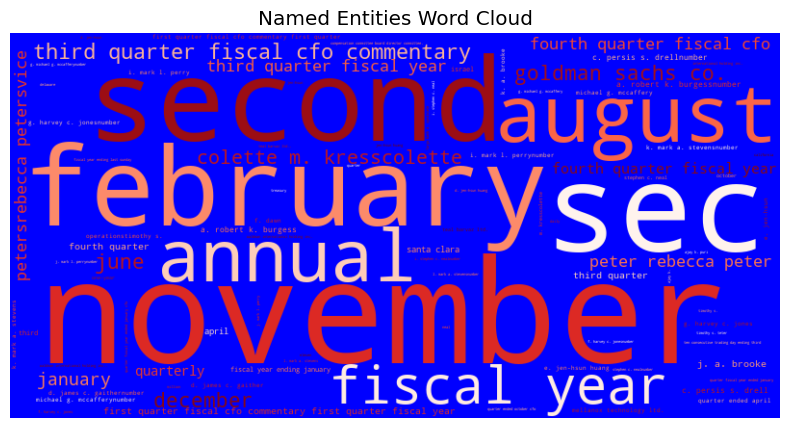

In [26]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color="blue", colormap="Reds",
                   max_font_size=150, max_words=max_words)

    # Convert Series to frequency dictionary if needed
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Remove stopwords from the frequency counter
    if stopwords is not None:
        counter = {token: freq for token, freq in counter.items() if token not in stopwords}

    wc.generate_from_frequencies(counter)

    # Set Style for Background
    plt.style.use("ggplot")

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Aggregate named entities into a list
entity_list = [entity[0] for entities in filing_df['Entities'] for entity in entities]

# Count the frequency of each entity
entity_word_freq = Counter(entity_list)

# Generate the word cloud for named entities
wordcloud(entity_word_freq, title="Named Entities Word Cloud")

## TF-IDF (Term Frequency-Inverse Document Frequency) Analysis of Disclosure Text
This section transforms disclosure text into numerical data using a TF-IDF vectorizer, focusing on the top 50 terms. To ensure consistency, custom stop words are processed and applied. The transformed data is converted into a dense matrix and stored in a DataFrame, with document accession numbers as the index and terms as columns. This provides a clear view of term importance across documents, useful for further analysis.

In [27]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf.fit_transform(filing_df['Processed Disclosure Text'])

# Display top keywords
print(tfidf.get_feature_names_out())

['abstaining' 'agreement' 'amended' 'announces' 'broker' 'cfo' 'chief'
 'colette' 'commentary' 'company' 'corporationdate' 'date' 'dated'
 'description' 'duly' 'entitled' 'executive' 'exhibit' 'filed' 'filing'
 'financial' 'fiscal' 'incorporated' 'kress' 'march' 'may' 'mellanox'
 'merger' 'non' 'november' 'number' 'officer' 'plan' 'president' 'press'
 'quarter' 'rebecca' 'reference' 'release' 'report' 'result' 'second'
 'share' 'statement' 'subject' 'third' 'vice' 'votes' 'withheld' 'year']


In [28]:
# Process stop words to match text splitting due to warning
processed_stopwords_TFIDF = list(TfidfVectorizer().build_tokenizer()(" ".join(stopwords_list)))

# Create the TF-IDF vectorizer with consistent stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=processed_stopwords_TFIDF, max_features=50)
tfidf_matrix = tfidf_vectorizer.fit_transform(filing_df['Processed Disclosure Text'])

# Display the shape of the TF-IDF matrix
print(tfidf_matrix.shape)

(50, 50)


In [29]:
# Convert to dense matrix
dense_matrix_TFIDF = tfidf_matrix.toarray()

# Get feature names from vectorizer
feature_names_TFIDF = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame with feature names as columns and document IDs as index
df_vectors_TFIDF = pd.DataFrame(dense_matrix_TFIDF, columns=feature_names_TFIDF, index=filing_df['Accession Number'])

# Display the DataFrame
df_vectors_TFIDF.head()

,abstaining,agreement,amended,announces,broker,cfo,chief,colette,commentary,company,...,result,second,share,statement,subject,third,vice,votes,withheld,year
Accession Number,,,,,,,,,,,,,,,,,,,,,
000104581016000292,0.0,0.000000,0.000000,0.231133,0.0,0.172150,0.071354,0.109432,0.172150,0.000000,...,0.319941,0.572842,0.0,0.000000,0.000000,0.000000,0.064100,0.0,0.0,0.176601
000104581016000292,0.0,0.000000,0.177611,0.000000,0.0,0.293533,0.081111,0.082930,0.391378,0.279385,...,0.181843,0.000000,0.0,0.126857,0.103033,0.000000,0.072864,0.0,0.0,0.000000
000104581016000343,0.0,0.000000,0.175983,0.000000,0.0,0.290844,0.080368,0.082170,0.387792,0.276825,...,0.180177,0.000000,0.0,0.125695,0.102089,0.000000,0.072197,0.0,0.0,0.000000
000104581016000343,0.0,0.000000,0.000000,0.225547,0.0,0.167991,0.069630,0.106788,0.167991,0.000000,...,0.312210,0.000000,0.0,0.000000,0.000000,0.486818,0.062551,0.0,0.0,0.172333
000104581016000358,0.0,0.524589,0.000000,0.000000,0.0,0.000000,0.178983,0.274497,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.160786,0.0,0.0,0.000000


## Text Classification with Random Forest and LOOCV
This section splits the dataset into training and test sets, vectorizes the text data using TF-IDF, computes class weights to handle class imbalance, and performs hyperparameter tuning on a Random Forest classifier using Leave-One-Out Cross-Validation (LOOCV). The best model is used to predict on the test set, and the performance is evaluated with a classification report.

In [30]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    filing_df['Processed Disclosure Text'], filing_df['Item'], 
    test_size=0.3, random_state=42
)

In [31]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Use LeaveOneOut Cross-Validation
loo = LeaveOneOut()

# Perform GridSearch with LOOCV and class weights
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights_dict), 
    param_grid, cv=loo, scoring='f1_weighted'
)
grid_search.fit(X_train_vec, y_train)

# Use the best estimator
best_clf = grid_search.best_estimator_


In [32]:
# Predict on test set
y_pred = best_clf.predict(X_test_vec)

# Display classification metrics
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

    ITEM 101       1.00      1.00      1.00         1
    ITEM 202       1.00      1.00      1.00         4
    ITEM 302       0.50      1.00      0.67         1
    ITEM 502       1.00      0.50      0.67         2
    ITEM 507       1.00      1.00      1.00         2
    ITEM 901       0.80      0.80      0.80         5

    accuracy                           0.87        15
   macro avg       0.88      0.88      0.86        15
weighted avg       0.90      0.87      0.87        15



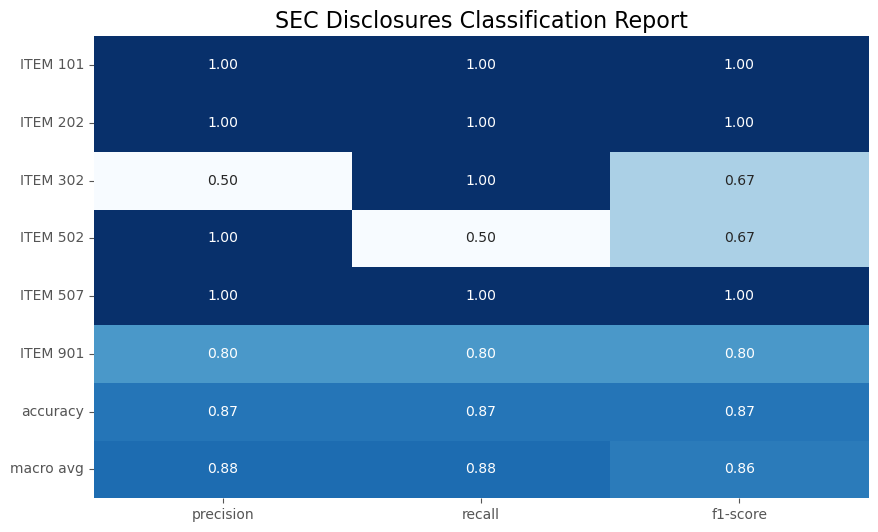

In [49]:
# Predict on test set
y_pred = best_clf.predict(X_test_vec)

# Generate classification metrics
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot heatmap for better visualization
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=False)

# Add title and adjust layout
plt.title("SEC Disclosures Classification Report", fontsize=16)
plt.show()

## Fit NMF Model and Display Top Words per Topic
This code fits a Non-negative Matrix Factorization (NMF) model with 5 topics on a TF-IDF matrix. It identifies the top 10 words for each topic and prints them along with their corresponding weights, highlighting the key terms representing each topic.

In [33]:
# Fit NMF model with 5 topics
nmf_text_model = NMF(n_components=5, random_state=42)
W_nmf_text_matrix = nmf_text_model.fit_transform(tfidf_matrix)
H_nmf_text_matrix = nmf_text_model.components_

# Number of top words to display per topic
num_top_words = 10

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Loop through each topic and display the top words with weights rounded to 4 decimal places
for topic_idx, topic in enumerate(H_nmf_text_matrix):
    top_features = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    top_features_weights = [round(topic[i], 4) for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic #{topic_idx + 1}:")
    print("Words:", top_features)
    print("Weights:", top_features_weights)
    print("\n")

Topic #1:
Words: ['fiscal', 'quarter', 'result', 'financial', 'entitled', 'announces', 'dated', 'colette', 'third', 'cfo']
Weights: [0.8577, 0.8118, 0.7669, 0.7254, 0.5963, 0.5525, 0.5463, 0.5373, 0.4598, 0.4053]


Topic #2:
Words: ['plan', 'president', 'march', 'year', 'amended', 'exhibit', 'vice', 'statement', 'fiscal', 'duly']
Weights: [1.4797, 0.5365, 0.5347, 0.4742, 0.446, 0.3667, 0.332, 0.2842, 0.2821, 0.2312]


Topic #3:
Words: ['filing', 'commentary', 'incorporated', 'company', 'reference', 'press', 'release', 'cfo', 'amended', 'financial']
Weights: [0.9208, 0.8608, 0.7399, 0.7075, 0.7043, 0.65, 0.65, 0.6363, 0.4571, 0.3684]


Topic #4:
Words: ['agreement', 'company', 'second', 'dated', 'filed', 'exhibit', 'mellanox', 'colette', 'merger', 'description']
Weights: [1.0983, 0.5437, 0.2655, 0.2531, 0.2477, 0.2262, 0.2147, 0.1962, 0.1912, 0.1902]


Topic #5:
Words: ['number', 'share', 'abstaining', 'broker', 'votes', 'non', 'withheld', 'mellanox', 'merger', 'march']
Weights: [0.9113

## Fit LSA Model and Display Top Words per Topic
This code fits a Latent Semantic Analysis (LSA) model using TruncatedSVD with 5 topics on a TF-IDF matrix. It identifies the top 10 words for each topic, displaying them with their corresponding weights to highlight key terms.

In [34]:
# Fit LSA model (TruncatedSVD) with 5 topics
lsa_text_model = TruncatedSVD(n_components=5, random_state=42)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_matrix)
H_lsa_text_matrix = lsa_text_model.components_

# Number of top words to display per topic
num_top_words = 10

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Loop through each topic and display the top words with weights rounded to 4 decimal places
for topic_idx, topic in enumerate(H_lsa_text_matrix):
    top_features = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    top_features_weights = [round(topic[i], 4) for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic #{topic_idx + 1}:")
    print("Words:", top_features)
    print("Weights:", top_features_weights)
    print("\n")

Topic #1:
Words: ['commentary', 'financial', 'quarter', 'press', 'release', 'result', 'cfo', 'company', 'fiscal', 'filing']
Weights: [0.2844, 0.262, 0.2464, 0.2351, 0.2351, 0.234, 0.2329, 0.2269, 0.2154, 0.2071]


Topic #2:
Words: ['plan', 'agreement', 'march', 'president', 'number', 'description', 'dated', 'year', 'vice', 'share']
Weights: [0.432, 0.363, 0.2427, 0.2139, 0.1684, 0.167, 0.1548, 0.153, 0.1454, 0.1335]


Topic #3:
Words: ['fiscal', 'entitled', 'announces', 'quarter', 'result', 'dated', 'third', 'financial', 'colette', 'november']
Weights: [0.2753, 0.2342, 0.2169, 0.2161, 0.2044, 0.193, 0.162, 0.1472, 0.1425, 0.1207]


Topic #4:
Words: ['agreement', 'company', 'second', 'dated', 'colette', 'mellanox', 'merger', 'kress', 'share', 'november']
Weights: [0.6227, 0.2609, 0.1944, 0.1597, 0.1166, 0.1056, 0.1053, 0.0767, 0.0633, 0.0627]


Topic #5:
Words: ['number', 'share', 'abstaining', 'broker', 'votes', 'non', 'withheld', 'mellanox', 'merger', 'result']
Weights: [0.6114, 0.538

## Fit LDA Model and Display Top Words per Topic
This code fits a Latent Dirichlet Allocation (LDA) model with 5 topics on a TF-IDF matrix. It extracts the top 10 words for each topic and displays them with their respective weights, providing insight into the dominant terms defining each topic.

In [35]:
# Fit LDA model with 5 topics
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(tfidf_matrix)
H_lda_text_matrix = lda_text_model.components_

# Number of top words to display per topic
num_top_words = 10

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Loop through each topic and display the top words with weights rounded to 4 decimal places
for topic_idx, topic in enumerate(lda_text_model.components_):
    top_features = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    top_features_weights = [round(topic[i], 4) for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic #{topic_idx + 1}:")
    print("Words:", top_features)
    print("Weights:", top_features_weights)
    print("\n")

Topic #1:
Words: ['fiscal', 'financial', 'quarter', 'colette', 'result', 'dated', 'vice', 'entitled', 'chief', 'president']
Weights: [5.0653, 4.0464, 3.7086, 3.5768, 3.4685, 3.3706, 2.8757, 2.7436, 2.7428, 2.734]


Topic #2:
Words: ['filing', 'commentary', 'incorporated', 'reference', 'release', 'press', 'company', 'cfo', 'amended', 'financial']
Weights: [4.3355, 4.07, 3.4934, 3.3251, 3.2977, 3.2977, 3.2866, 3.0945, 2.2206, 2.033]


Topic #3:
Words: ['third', 'financial', 'subject', 'may', 'november', 'year', 'fiscal', 'date', 'report', 'executive']
Weights: [0.2004, 0.2004, 0.2003, 0.2003, 0.2003, 0.2003, 0.2003, 0.2002, 0.2002, 0.2002]


Topic #4:
Words: ['plan', 'agreement', 'company', 'march', 'filed', 'exhibit', 'amended', 'may', 'president', 'report']
Weights: [5.4342, 4.5092, 3.1816, 2.8656, 2.0381, 1.9947, 1.9266, 1.8916, 1.6373, 1.2834]


Topic #5:
Words: ['statement', 'number', 'mellanox', 'share', 'merger', 'abstaining', 'broker', 'votes', 'non', 'withheld']
Weights: [2.4334

## Comparison of Topics vs. Items (Disclosures)

In [36]:
# Initialize the vectorizer with consistent features
vectorizer = TfidfVectorizer(max_features=820, stop_words='english')

# Fit the vectorizer on the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

# Train NMF, LSA, and LDA models using the same vectorized training data
nmf_text_model = NMF(n_components=5, random_state=42)
nmf_text_model.fit(X_train_vec)

lsa_text_model = TruncatedSVD(n_components=5, random_state=42)
lsa_text_model.fit(X_train_vec)

lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_text_model.fit(X_train_vec)

# Predict topics for each document in the test set
df = pd.DataFrame()  # Initialize DataFrame for results
df['nmf_topic'] = np.argmax(nmf_text_model.transform(X_test_vec), axis=1)
df['lsa_topic'] = np.argmax(lsa_text_model.transform(X_test_vec), axis=1)
df['lda_topic'] = np.argmax(lda_text_model.transform(X_test_vec), axis=1)

# Add the original Item category labels to the DataFrame
df['item_category'] = y_test.reset_index(drop=True)

In [37]:
# Create crosstabs to compare NMF with Item categories (Disclosures)
print("\nNMF Model Category Tally:")
nmf_category_tally = pd.crosstab(df['nmf_topic'], df['item_category'])
print(nmf_category_tally)


NMF Model Category Tally:
item_category  ITEM 101  ITEM 202  ITEM 302  ITEM 502  ITEM 507  ITEM 901
nmf_topic                                                                
0                     0         0         1         0         0         3
1                     0         4         0         0         0         0
2                     0         0         0         2         0         0
3                     1         0         0         0         2         2


In [38]:
# Create crosstabs to compare LSA with Item categories (Disclosures)
print("\nLSA Model Category Tally:")
lsa_category_tally = pd.crosstab(df['lsa_topic'], df['item_category'])
print(lsa_category_tally)


LSA Model Category Tally:
item_category  ITEM 101  ITEM 202  ITEM 302  ITEM 502  ITEM 507  ITEM 901
lsa_topic                                                                
0                     0         3         1         0         0         3
1                     0         1         0         0         0         0
2                     0         0         0         2         2         0
3                     1         0         0         0         0         2


In [39]:
# Create crosstabs to compare LDS with Item categories (Disclosures)
print("\nLDA Model Category Tally:")
lda_category_tally = pd.crosstab(df['lda_topic'], df['item_category'])
print(lda_category_tally)


LDA Model Category Tally:
item_category  ITEM 101  ITEM 202  ITEM 302  ITEM 502  ITEM 507  ITEM 901
lda_topic                                                                
0                     0         0         1         0         0         0
1                     0         4         0         0         0         0
2                     0         0         0         0         0         4
3                     0         0         0         0         2         1
4                     1         0         0         2         0         0


In [42]:
# Initialize the vectorizer with consistent features
vectorizer = TfidfVectorizer(max_features=820, stop_words='english')

# Fit and transform the vectorizer on the entire dataset (or training data)
tfidf_matrix = vectorizer.fit_transform(X_train)

# Train the LDA model using the same tfidf_matrix
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_text_model.fit(tfidf_matrix)

# Visualize LDA topics using pyLDAvis with the same tfidf_matrix and vectorizer
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, tfidf_matrix, vectorizer, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)

<center><b>References:</b></center>

- Farkhod, A., Abdusalomov, A., Makhmudov, F., & Cho, Y. I. (2021). *LDA-based topic modeling sentiment analysis using topic/document/sentence (TDS) model.* Applied Sciences, 11(23), 11091. https://doi.org/10.3390/app112311091
- Reddy, B. R., Reddy, D. S. T., Preetham, S. M. C., Rajasekhar, A. H. N., & Subramani, R. (2022). *Comparative study analysis on news articles categorization using LSA and NMF approaches.* 2022 13th International Conference on Computing, Communication, and Networking Technologies (ICCCNT). https://doi.org/10.1109/ICCCNT54827.2022.9984466
- Egger, R., & Yu, J. (2022). *A topic modeling comparison between LDA, NMF, Top2Vec, and BERTopic to demystify Twitter posts.* Frontiers in Sociology, 7(886498). https://doi.org/10.3389/fsoc.2022.886498
- Albrecht, J., Ramachandran, S., & Winkler, C. (2020). *Blueprints for text analytics using Python.* O'Reilly.
- Pankaj. (2022, August 3). *Python string encode() decode().* DigitalOcean. https://www.digitalocean.com/community/tutorials/python-string-encode-decode
- Getbags, A. (2023, February 12). *SEC EDGAR API Python tutorial - Get SEC filing and financial data* [Video]. YouTube. https://www.youtube.com/watch?v=secAPI
- Sigma Coding. (2019, April 8). *How to web scrape the SEC | Part 1* [Video]. YouTube. https://www.youtube.com/watch?v=secScraping
- Jain, Y. (2021, February 23). *How to convert a string to UTF-8 in Python?* Studytonight. https://www.studytonight.com/python-howtos/how-to-convert-a-string-to-utf8-in-python
- Singh, V. K., & Obi Tulton, A. (2022, November 30). *How to work with Unicode in Python.* DigitalOcean. https://www.digitalocean.com/community/tutorials/how-to-work-with-unicode-in-python
- Solomon, B. (2021, August 29). *demoji (Version 1.1.0)* [Python package]. PyPI. https://pypi.org/project/demoji/
- pythontutorial.net. (2023). *Python regex sub().* https://www.pythontutorial.net/python-regex/python-regex-sub/
- Unicode Table. (n.d.). *UTF-8 encoding table and Unicode characters: Code points U+2000 to U+207F.* Retrieved from https://www.utf8-chartable.de/unicode-utf8-table.pl?start=8192&number=128&utf8=string-literal
- OpenAI. (2023). ChatGPT (October 5 version) [Large language model]. https://chat.openai.com/
- scikit-learn developers. (2024). *Feature extraction.* Scikit-learn. https://scikit-learn.org/stable/modules/feature_extraction.html
- Saket, S. (2020, January 12). *Count vectorizer vs TFIDF vectorizer | Natural language processing.* LinkedIn. https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/
- Jablonski, J. (2023, October 18). *Python's F-String: An improved string interpolation and formatting tool.* Real Python. https://realpython.com/python-f-strings/
- Shah, F. P., & Patel, V. (2016). *A review on feature selection and feature extraction for text classification.* 2016 International Conference on Wireless Communications, Signal Processing and Networking (WiSPNET), 2264–2268. https://doi.org/10.1109/WiSPNET.2016.
- Bird, S., Klein, E., & Loper, E. (2019). *Accessing text corpora and lexical resources.* Natural Language Toolkit. http://www.nltk.org/book/ch02.html
- DataCamp. (2024, January 31). *A beginner's guide to Python for loops: Mastering for i in range.* DataCamp. https://www.datacamp.com/tutorial/python-for-i-in-range
- NumPy Developers. (2024). *numpy.argmax.* NumPy. https://numpy.org/doc/2.0/reference/generated/numpy.argmax.html